# Discretization and clustering

We'll discretize trajectories using the [H3 library](https://uber.github.io/h3-py/intro.html) and then use a metric that is designed to compare discrete sequences (like strings) in the clustering.

## Get data

We'll download one file from https://zenodo.org/record/4650317.
This only needs to be executed once.

In [1]:
# !mkdir -p data/
# !curl \
#     -o data/trajectories_stokes_subset_10000.csv.gz \
#     https://zenodo.org/record/4650317/files/trajectories_stokes_subset_10000.csv.gz
# !gunzip -f -v data/trajectories_stokes_subset_10000.csv.gz

## Prepare env

In [2]:
import numpy as np
import pandas as pd

## Parameters

In [3]:
num_traj = 600
random_trajs = False
h3_resolution = 6  # approx 3000m
h3_number_cutoff = 25  # approx 75km
random_seed = 12345

In [4]:
np.random.seed(random_seed)  # reproducibility!

## Load data and extract a few trajectories

In [5]:
def load_and_subset_trajectories(
    file_name, num_traj=300, use_random=False
):
    """Load data file and extract a number of trajectories.
    
    Parameters
    ----------
    file_name: str or Path
        File to open.
    num_traj: int
        Number of trajectories to load
    use_random: book
        If true, choose num_traj trajectories at random.
        If false, choose first num_traj trajectories.
    
    Returns
    -------
    pandas.DataFrame
        Trajectorie

    """

    df = pd.read_csv(file_name)

    # the whole dataset is too big to open here.
    if use_random:
        # Let's subset to fewer random trajectories:
        random_trajs = np.random.choice(
            np.unique(df["traj"]), num_traj, replace=False
        )
        traj_mask = df["traj"].apply(lambda x: x in random_trajs)
    else:
        # Let's use the first N trajectories
        first_n_trajs = np.unique(df["traj"])[:num_traj]
        traj_mask = df["traj"].apply(lambda x: x in first_n_trajs)
    
    df = df[traj_mask]
    
    return df

In [6]:
df = load_and_subset_trajectories(
    "data/trajectories_stokes_subset_10000.csv",
    num_traj=num_traj,
    use_random=random_trajs,
)

df = df[["traj", "obs", "lat", "lon"]]

df = df.set_index(["traj", "obs"])

df = df.sort_index(axis=0, level=0)

display(df)

lat       lon
traj obs                     
0    0    43.288517  5.171321
     1    43.285854  5.181101
     2    43.283524  5.190491
     3    43.281498  5.199454
     4    43.279760  5.208031
...             ...       ...
599  957  40.695263  5.380426
     958  40.693634  5.382443
     959  40.692062  5.384488
     960  40.690550  5.386559
     961  40.690430  5.386733

[577200 rows x 2 columns]

## Discretize with H3

In [7]:
import h3
import h3.api.numpy_int
import h3.api.basic_str

In [8]:
def get_h3_bins(lat=None, lon=None, resolution=8):
    """Convert series of lat and lon to series of h3s.
    
    Parameters
    ----------
    lat: pandas.Series
        Series of latitudes.
    lon: pandas.Series
        Series of longitudes.
    resolution: int
        H3 resolution. Default to 8 corresponding to approx. 500 meters.
        
    Returns
    -------
    pandas.Series
        h3s
    
    """
    return pd.Series(
        data=map(
            lambda ll: h3.geo_to_h3(*ll, resolution=resolution),
            zip(lat, lon)
        ),
        index=lat.index
    )

In [9]:
%time df["h3"] = get_h3_bins(df["lat"], df["lon"], resolution=h3_resolution)

CPU times: user 952 ms, sys: 12.2 ms, total: 965 ms
Wall time: 963 ms


In [10]:
df

lat       lon               h3
traj obs                                      
0    0    43.288517  5.171321  863968117ffffff
     1    43.285854  5.181101  863968117ffffff
     2    43.283524  5.190491  863968117ffffff
     3    43.281498  5.199454  863968117ffffff
     4    43.279760  5.208031  863968117ffffff
...             ...       ...              ...
599  957  40.695263  5.380426  86394ea27ffffff
     958  40.693634  5.382443  86394ea27ffffff
     959  40.692062  5.384488  86394ea27ffffff
     960  40.690550  5.386559  86394ea27ffffff
     961  40.690430  5.386733  86394ea27ffffff

[577200 rows x 3 columns]

## How many distinct H3s (at the given resolution) are there in a typical trajectory?

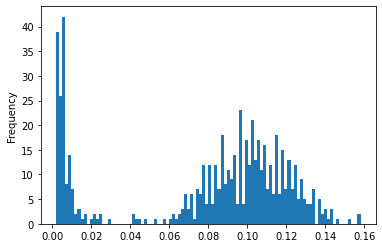

In [11]:
frac = []
for traj in df.index.levels[0]:
    frac.append(
        len(np.unique(df.loc[traj]["h3"]))
        / len(df.loc[traj])
    )
frac = pd.Series(data=frac, index=df.index.levels[0])

frac.plot.hist(bins=100);

## Visualize polygons

In [12]:
from matplotlib import pyplot as plt
from shapely.geometry import Polygon
import geopandas

In [13]:
%%time

polys = geopandas.GeoSeries(
    map(
        lambda h: Polygon(h3.h3_to_geo_boundary(h, geo_json=True)),
        df["h3"]
    ),
    index=df["h3"].index,
    crs="EPSG:4326",
)

CPU times: user 8.77 s, sys: 112 ms, total: 8.89 s
Wall time: 8.88 s


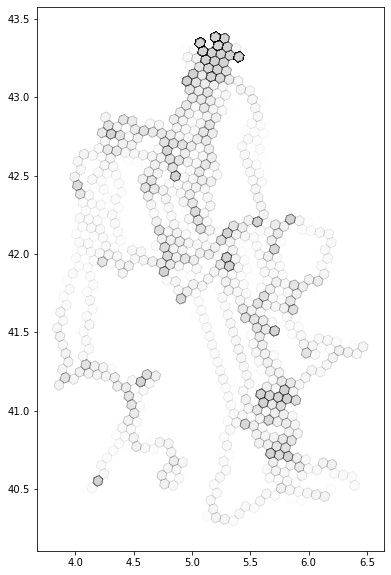

In [14]:
ax = polys.iloc[:10_000].plot(
    alpha=0.01,
    color="lightgray",
    figsize=(10, 10),
    edgecolor="black", 
)

## Collapse trajectories

We'll remove all consecutive duplicates from the trajectories.

In [15]:
def _get_unique_index(trajectory):
    def _collapse(sequence):
        last = None
        for n, element in enumerate(sequence):
            if element != last:
                yield n
            last = element
    return trajectory.index[list(_collapse(trajectory))]

In [16]:
_get_unique_index(pd.Series([0, 1, 2, 2, 3]))

Int64Index([0, 1, 2, 4], dtype='int64')

In [17]:
traj = df.loc[df.index.levels[0][0]]
traj

,lat,lon,h3
obs,,,
0,43.288517,5.171321,863968117ffffff
1,43.285854,5.181101,863968117ffffff
2,43.283524,5.190491,863968117ffffff
3,43.281498,5.199454,863968117ffffff
4,43.279760,5.208031,863968117ffffff
...,...,...,...
957,43.266370,5.374965,86396802fffffff
958,43.266370,5.374965,86396802fffffff
959,43.266370,5.374965,86396802fffffff


In [18]:
df_collapsed = pd.concat(
    (
        df.loc[_traj].loc[_get_unique_index(df.loc[_traj]["h3"])]
        for _traj in df.index.levels[0]
    ),
    keys=df.index.levels[0],
)

In [19]:
df_collapsed

lat       lon               h3
traj obs                                      
0    0    43.288517  5.171321  863968117ffffff
     5    43.278210  5.216301  86396811fffffff
     17   43.263443  5.285539  863968027ffffff
     64   43.300280  5.326179  86396810fffffff
     76   43.347170  5.283669  86396812fffffff
...             ...       ...              ...
599  844  40.728470  5.207891  86394eb17ffffff
     886  40.753320  5.275041  86394eb07ffffff
     931  40.755733  5.331959  86394eb0fffffff
     932  40.753593  5.334185  86394eb1fffffff
     946  40.717350  5.359995  86394ea27ffffff

[47954 rows x 3 columns]

<AxesSubplot:ylabel='Frequency'>

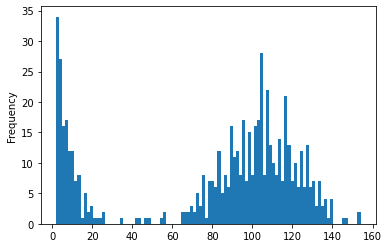

In [20]:
pd.Series([len(df_collapsed.loc[traj]) for traj in df_collapsed.index.levels[0]]).plot.hist(bins=100)

Note that this looks similar to the total count of different H3s per trajectory plotted above. This is expected, as trajectories typically are non-local and don't revisit places. 

## Remove very short trajectories

In [21]:
number_of_h3s = pd.Series(
    [len(df_collapsed.loc[traj]) for traj in df_collapsed.index.levels[0]],
    index=df_collapsed.index.levels[0]
)
number_of_h3s

traj
0        9
1       95
2      108
3      112
4      109
      ... 
595     92
596     88
597     89
598    106
599     99
Length: 600, dtype: int64

<AxesSubplot:xlabel='traj'>

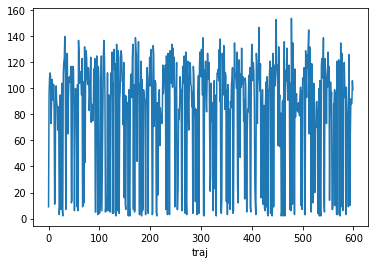

In [22]:
number_of_h3s.plot()

In [24]:
long_trajectories = number_of_h3s.index[(number_of_h3s > h3_number_cutoff)]
long_trajectories

Int64Index([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,
            ...
            588, 589, 591, 592, 594, 595, 596, 597, 598, 599],
           dtype='int64', name='traj', length=451)

In [40]:
df_collapsed = pd.concat(
    (df_collapsed.loc[trj] for trj in long_trajectories),
    keys=long_trajectories
)

## Distance metric

In [43]:
import editdistance

In [44]:
def traj_editdist(traj_0, traj_1):
    return editdistance.eval(list(traj_0["h3"]), list(traj_1["h3"]))

In [45]:
traj_0_index = df_collapsed.index.levels[0][0]
traj_1_index = df_collapsed.index.levels[0][2]

In [46]:
%time traj_editdist(df.loc[traj_0_index], df.loc[traj_1_index])

CPU times: user 14.1 ms, sys: 115 µs, total: 14.2 ms
Wall time: 11.6 ms


959

In [48]:
%time traj_editdist(df_collapsed.loc[traj_0_index], df_collapsed.loc[traj_1_index])

CPU times: user 6.09 ms, sys: 115 µs, total: 6.21 ms
Wall time: 4.63 ms


112

## Cost and performance estimate

We'll have to evaluate the distance for all possible pairs of trajectories (`num_traj * (num_traj-1)`).
- For 1000 trajectories and on a single CPU, this will take
  - `14ms * 1_000 * 999 = 14_000s = 4h` for the full trajectories, and
  - `1ms * 1_000 * 999 = 1_000s = 1h` for the collapsed trajectories.
- For 10_000 trajectories and on a single CPU, this will take
  - `14ms * 10_000 * 9999 = 1_400_000s = 400h` for the full trajectories, and
  - `4ms * 10_000 * 9999 = 400_000s = 100h` for the collapsed trajectories.

As many of the clusterin algorithms are serial, we cannot easily use parallelisation to decrease these times if we calculate the metric while the clustering is running. We could, however, pre-compute them and submit a full distance matrix to (some of) the clustering algorithms.

However, this imposes another boundary: Size of the (float64) distance matrix.
- For 1_000 trajectories, distance matrix amounts to 8 MiB, compute takes 1h if 1 CPU, 2min if 32 CPU
- For 10_000 trajectories, distance matrix amounts to 800 MiB, compute takes 100h if 1 CPU, 3h if 32 CPU
- For 100_000 trajectories, distance matrix amounts to 80 GiB, compute takes 10_000h if 1 CPU
- For 353_553 trajectories, distance matrix amounts to 1 TiB, compute takes 1_000_000j if 1 CPU

## Clustering

In [49]:
from sklearn.cluster import DBSCAN, OPTICS, KMeans
from sklearn.metrics import pairwise_distances

### Data and metric prep

In [50]:
len(df_collapsed.index.levels[0])

451

In [51]:
X = np.arange(len(df_collapsed.index.levels[0])).reshape(-1, 1)
X.shape

(451, 1)

In [52]:
def wrapped_dist(x, y, **kwargs):
    i, j = int(x[0]), int(y[0])
    tind0 = df_collapsed.index.levels[0][i]
    tind1 = df_collapsed.index.levels[0][j]
    t0 = df_collapsed.loc[tind0]
    t1 = df_collapsed.loc[tind1]
    norm = max(len(t0), len(t1))
    return traj_editdist(t0, t1) / norm

### Distance Matrix

In [53]:
%time dist = pairwise_distances(X[:10], metric=wrapped_dist, n_jobs=1)
%time dist = pairwise_distances(X[:100], metric=wrapped_dist, n_jobs=1)

CPU times: user 37.1 ms, sys: 5.92 ms, total: 43 ms
Wall time: 41.4 ms
CPU times: user 2.71 s, sys: 7.5 ms, total: 2.72 s
Wall time: 2.72 s


(array([1.000e+02, 0.000e+00, 0.000e+00, 2.000e+00, 1.200e+01, 1.200e+01,
        2.400e+01, 3.000e+01, 2.460e+02, 9.574e+03]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

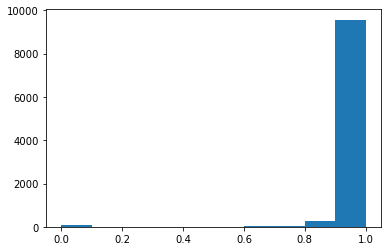

In [54]:
plt.hist(dist.flatten())

### Clustering

We need the full distance matrix.

In [55]:
%%time

dist = pairwise_distances(X, metric=wrapped_dist)

CPU times: user 57 s, sys: 535 µs, total: 57 s
Wall time: 57 s


In [56]:
np.median(dist.flatten()) - dist.flatten().std()

0.9272870602369813

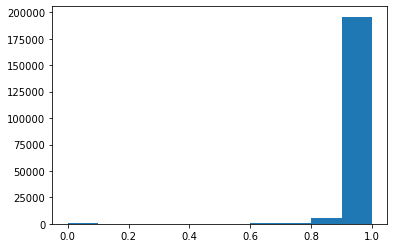

In [57]:
plt.hist(dist.flatten());

DBSCAN:

In [58]:
%%time

dbs = DBSCAN(
    metric="precomputed", min_samples=3, eps=0.8,
)

dbs_ids = dbs.fit_predict(dist)

CPU times: user 5.35 ms, sys: 8.05 ms, total: 13.4 ms
Wall time: 3.86 ms


In [59]:
display(dbs_ids.shape)
display(dbs_ids.max())

(451,)

24

(array([169., 142.,  39.,  12.,  22.,   6.,  18.,  17.,  16.,  10.]),
 array([-1. ,  1.5,  4. ,  6.5,  9. , 11.5, 14. , 16.5, 19. , 21.5, 24. ]),
 <BarContainer object of 10 artists>)

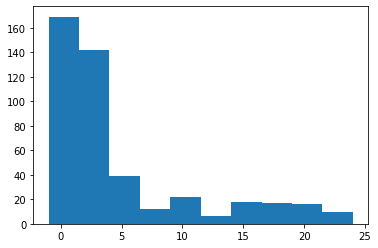

In [60]:
plt.hist(dbs_ids)

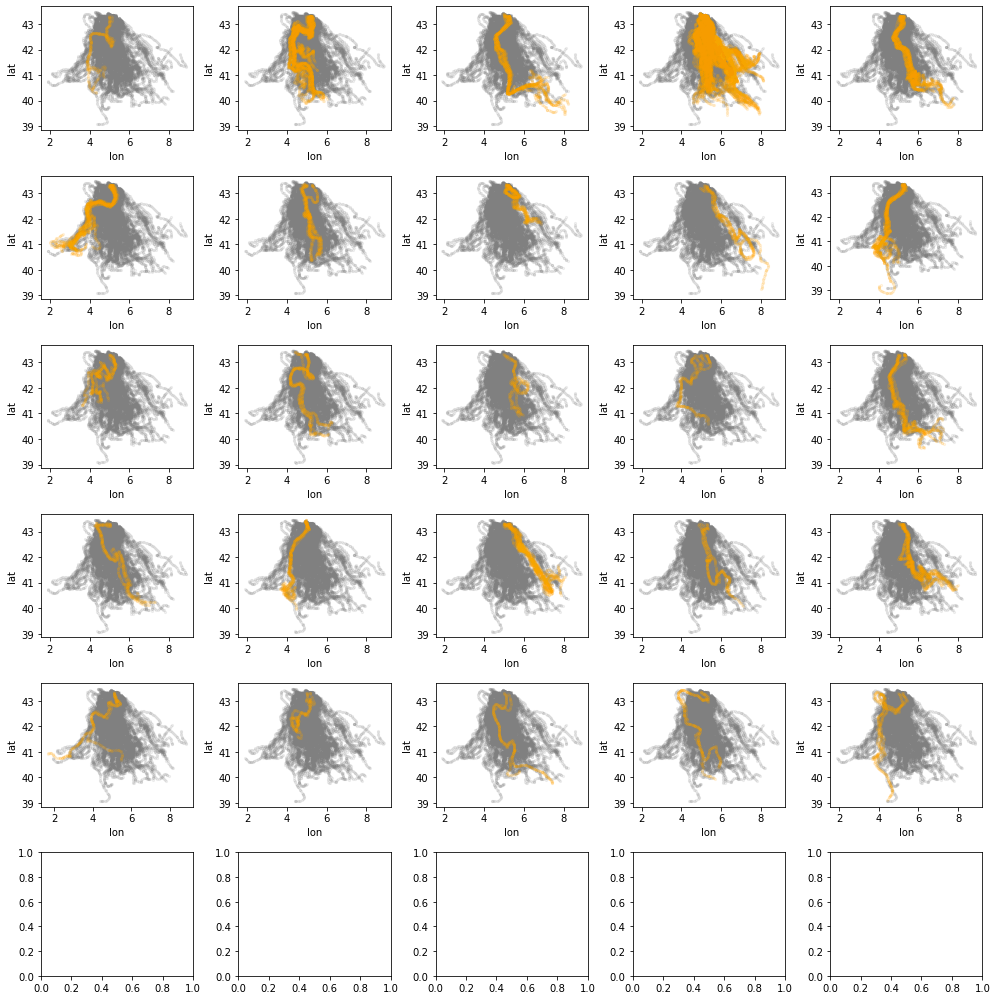

In [70]:
fig, ax = plt.subplots(6, 5, figsize=(14, 14))

ax = ax.flatten()

for _ax, cl in zip(ax, range(dbs_ids.max() + 1)):
    df_collapsed.loc[df_collapsed.index.levels[0][dbs_ids == -1]].plot.scatter(
        x="lon", y="lat", color="gray", s=5, alpha=0.1, ax=_ax
    );
    df_collapsed.loc[df_collapsed.index.levels[0][dbs_ids == cl]].plot.scatter(
        x="lon", y="lat", s=5, color="orange", alpha=0.1, ax=_ax
    );

fig.tight_layout();

OPTICS:

In [63]:
%%time

optics = OPTICS(
    metric="precomputed", min_samples=2, max_eps=1.0,
)

optics_ids = optics.fit_predict(dist)

CPU times: user 169 ms, sys: 0 ns, total: 169 ms
Wall time: 167 ms


In [64]:
display(optics_ids.shape)
display(optics_ids.max())

(451,)

100

(array([208.,  34.,  26.,  31.,  26.,  25.,  23.,  24.,  29.,  25.]),
 array([ -1. ,   9.1,  19.2,  29.3,  39.4,  49.5,  59.6,  69.7,  79.8,
         89.9, 100. ]),
 <BarContainer object of 10 artists>)

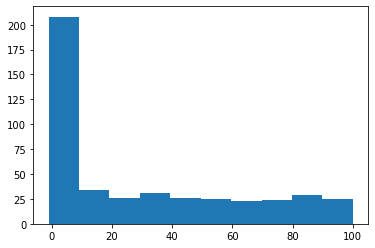

In [65]:
plt.hist(optics_ids)

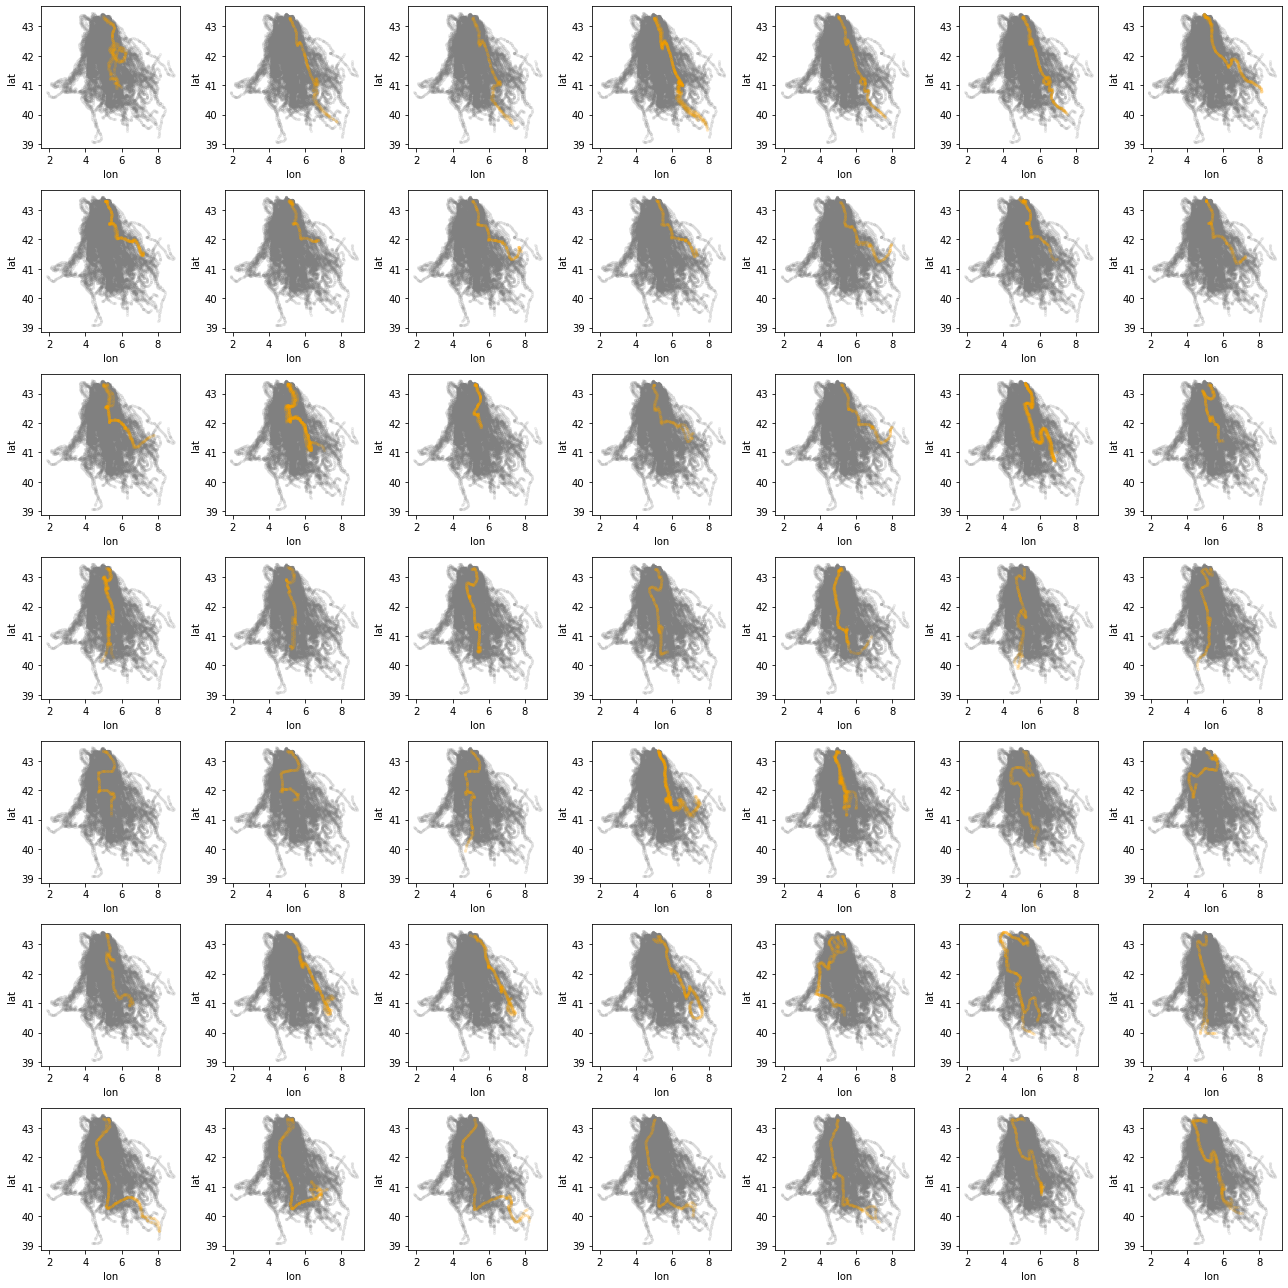

In [69]:
fig, ax = plt.subplots(7, 7, figsize=(18, 18))

ax = ax.flatten()

for _ax, cl in zip(ax, range(optics_ids.max() + 1)):
    df_collapsed.loc[df_collapsed.index.levels[0][optics_ids == -1]].plot.scatter(
        x="lon", y="lat", color="gray", s=5, alpha=0.1, ax=_ax
    );
    df_collapsed.loc[df_collapsed.index.levels[0][optics_ids == cl]].plot.scatter(
        x="lon", y="lat", s=5, color="orange", alpha=0.1, ax=_ax
    );
    
fig.tight_layout();